# Mental Health on Social Media - NLP Project

Denise Emmermacher / Raquel Bux Sanz

## Introduction

Social Media has a big impact in our lives and mental health. Studies show us that toxic behaviour and also cyberbullyng can affect directly in our mood, possibly creating conditions that can contribute for some specific sintoms of depression, anxiety and other deseases.

Nowadays it is possible to see that through these platforms (like Reddit, Twitter, Facebook and others), we can also know more about the person that is behind the screen and detect, by the language, if this person might be suffering from depression or not.

In our project we intend to use Natural Language Processing (NLP) to detect posts and comments with depressive content in order to help people to improve their emotional and mental health.

## Datasets

We are going to work with 3 datasets: 

1) Posts of Reddit

This dataset was found in Kaggle and contain posts of Reddit, collected from Dec 16th 2008 until Jan 2th 2021, using Pushshift API. The dataset assumes posts collected from 'SuicideWatch' (an intensive monitoring process used to ensure that any person cannot attempt suicide - https://reddit.com/r/SuicideWatch/) contains suicide related content. Similarly we have other classes 'depression' (https://reddit.com/r/depression/) and 'teenagers' (https://reddit.com/r/teenagers/) collected from respective subreddits.

The target column (class) detects if the post is "depressive" (1) or "not-depressive" (0).

Key figures:

- 232.074 rows 
- 3 columns 
- 1 text column
- 2 numeric columns

2) Tweets with depression content

The dataset that we found in Kaggle was taken by the websraper with the name of TWINT using the keyword depression by scraping all tweets in an one day span. The tweets which taken as the result of the scrapper may contain tweets that do not shows the user have the depression, such as tweets such as tweets linking to articles about depression. 

- 10314 rows 
- 3 columns
- 1 text column
- 2 numeric columns

3) Positive reviews on IMDb

This is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

- 50000 rows 
- 2 columns
- 1 text column
- 1 numeric columns





## Strutcture of this Notebook

NLP (using the dataset of Posts on Reddit)
- Cleaning data, Merging Posts, Text Cleaning, Tokenizing Corpus, Reducing Corpus, Stemming and Creating Dataframe for Making Predictions based on the Tree Model;
- Cleaning data and using TDF-DF to generate other model of Tree, with a greater amount of keywords. This model will be optimized with Grid Search.

EDA
- Cleaning data of the dataset we used to make EDA of the influence of Social Media in the mood and mental health of people (Dataset from ScienceDirect, a website which provides access to a large bibliographic database of scientific and medical publications of the Dutch publisher Elsevier);
- The EDA will be structured in tableau and in the canva presentation.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import seaborn as sns
import re
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, classification_report 
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


# Cleaning Data

## Data cleaning

The first step that we took for the cleaning was to change the words "suicide" and "non-suicide" for 1 and 0. The reason is because there's not only content about suicide, but also about depression and not every depressed person is able to commit suicide.

In [7]:
sd = pd.read_csv ('Suicide_Detection.csv')
sd

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [8]:
sd['class'] = sd['class'].map({'suicide': 1, 'non-suicide': 0})

In [9]:
sd

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,0
2,4,Finally 2020 is almost over... So I can never ...,0
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,0
232070,348106,You how you can tell i have so many friends an...,0
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,348108,The usual stuff you find hereI'm not posting t...,1


Checking the missing values.

In [10]:
sd.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

Dropping the column "Unnamed: 0"

In [11]:
sd = sd[['text','class']]
sd.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


Checking if the data is balanced.

In [12]:
sd['class'].value_counts()

1    116037
0    116037
Name: class, dtype: int64

The classes are balanced. That's a good sign. 

## Splitting in two DF's

Now we are going to analyse the amount of words each class have. For that we will split the dataframe in two:


- dep: Only containing the posts labeled with depressive content;
- ndep: containing the posts that are considered not-depressive.








In [13]:
dep = sd[sd['class'] == 1]
dep.shape

(116037, 2)

In [14]:
ndep = sd[sd['class'] == 0]
ndep.shape

(116037, 2)

## Filtering the lenght

Now let's get the length of each type of class adding the column "length" in the two dataframes, using the lambda function. With this we will know the number of words of each post. This will help us to filter the data for a better performance of the model.

In [15]:
dep['length'] = list(map(lambda x: len(str(x).split()), dep['text']))

In [16]:
dep.head()

,text,class,length
0,Ex Wife Threatening SuicideRecently I left my ...,1,143
3,i need helpjust help me im crying so hard,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,438
5,Honetly idkI dont know what im even doing here...,1,291
6,[Trigger warning] Excuse for self inflicted bu...,1,243


Checking the outliers... We can see that the majority of the posts have not more that 1.000 words, meanwhile the outliers can reach around 10.000 words.

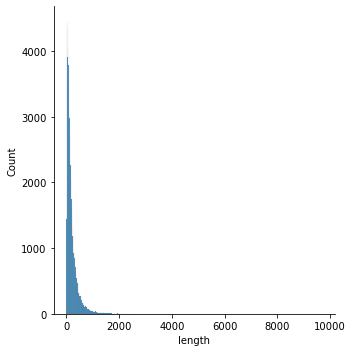

In [17]:
sns.displot(x=dep['length'])

In [18]:
dep['length'].describe()

count    116037.000000
mean        202.662168
std         255.309193
min           1.000000
25%          60.000000
50%         127.000000
75%         251.000000
max        9684.000000
Name: length, dtype: float64

The median of words are 127.

According to the median, a reasonable guess will be to filter out posts under the lenght of 150 words - a value a little bit bigger than the median.

In [19]:
dep = dep[dep['length'] < 150]
dep.shape

(65179, 3)

Repeating the same process with the dataframe of not-depressive posts: creating a column called "lenght" in the dataframe.

In [20]:
ndep['length'] = list(map(lambda x: len(str(x).split()), ndep['text']))

In [21]:
ndep.head()

,text,class,length
1,Am I weird I don't get affected by compliments...,0,27
2,Finally 2020 is almost over... So I can never ...,0,26
8,"Everyone wants to be ""edgy"" and it's making me...",0,195
15,Fuck the verizon smart family app I can’t even...,0,19
17,"Well, Im screwed. I locked myself in the schoo...",0,26


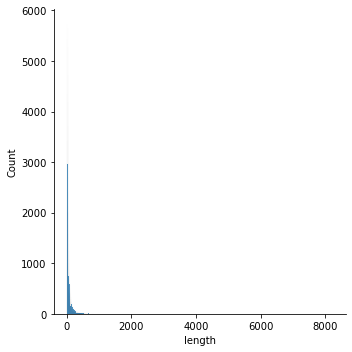

In [22]:
sns.displot(x=ndep['length'])

Posts with depressive content have a lot of more characters than the not-depressive posts. 
Here we can see the difference of the numbers of words in the post. Not depressive posts tend to have smaller texts.

In [23]:
ndep['length'].describe()

count    116037.000000
mean         61.188302
std         139.292553
min           2.000000
25%          19.000000
50%          31.000000
75%          60.000000
max        8220.000000
Name: length, dtype: float64

The median is also smaller.

Now we will filter the posts that are smaller than one value near the median (31). We think that under 36 words is a good way to filter.

In [24]:
ndep = ndep[ndep['length'] < 36]
print (dep.shape)
print (ndep.shape)

(65179, 3)
(64999, 3)


## Concatenating

After filtering the data by the lenght of the text of each class (that's the way we found to work with a final data that keeps the balance of the target column like in the original data), we will concatenate the two dataframes...


In [25]:
conc = pd.concat([dep, ndep], axis=0)

In [26]:
conc

,text,class,length
0,Ex Wife Threatening SuicideRecently I left my ...,1,143
3,i need helpjust help me im crying so hard,1,9
7,It ends tonight.I can’t do it anymore. \nI quit.,1,9
10,I took the rest of my sleeping pills and my pa...,1,29
11,Can you imagine getting old? Me neither.Wrinkl...,1,74
...,...,...,...
232064,How ba-a-ad can i be? I’m just doin’ what come...,0,26
232069,If you don't like rock then your not going to ...,0,19
232070,You how you can tell i have so many friends an...,0,31
232071,pee probably tastes like salty tea😏💦‼️ can som...,0,14


## Getting a sample

Reducing the dataframe to get around 70.000 rows.

In [27]:
sam = conc.sample(frac=0.54)

In [28]:
sam

,text,class,length
110290,I just feel likeThis will either pass and I'll...,1,34
203585,I officially have an anime pfp 😁😁 Swag,0,8
181818,Best username to comment gets an award Best us...,0,25
217317,My pc just died last night :( FFFFFFF\nF\nF\nF...,0,14
45563,"Developing suicidal thoughtsHi all,\n\nA coupl...",1,135
...,...,...,...
105742,The state of the world is so shit I see no poi...,1,90
205845,Ive finally done it No this isnt your usual an...,0,25
1502,What do I tell themI want to tell my friends a...,1,56
129171,"I was raped 10 months ago, and am male. I'm do...",1,93


##  Depression dataframe

The first dataframe had to much texts about suicide, so we wanted to put more texts about depression for a better performance of the model. The dataset that we found in Kaggle was taken by the websraper with the name of TWINT using the keyword depression by scraping all tweets in an one day span. The tweets which taken as the result of the scrapper may contain tweets that do not shows the user have the depression, such as tweets such as tweets linking to articles about depression. Hence, the scrapped tweets need to be manually check for the better testing results. 

In [29]:
tweets = pd.read_csv ('sentiment_tweets3.csv')
tweets

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [30]:
tweets = tweets[['message to examine','label (depression result)']]
tweets

,message to examine,label (depression result)
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [31]:
tweets.rename(columns={'message to examine':'text','label (depression result)':'class'}, 
          inplace=True, errors='raise')

In [32]:
tweets

,text,class
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [33]:
tweets.drop(10313,inplace=True, axis=0)

In [34]:
tweets.isnull().sum()

text     0
class    0
dtype: int64

In [35]:
tweets['class'].value_counts()

0    8000
1    2313
Name: class, dtype: int64

We are goint to drop the tweets that doesn't have content about depression, because we already have this kind of content in our first dataset:

In [36]:
to_drop = tweets[tweets['class'] == 0].index

In [37]:
tweets.drop(to_drop,inplace=True, axis=0)

In [38]:
tweets

,text,class
8000,The lack of this understanding is a small but ...,1
8001,i just told my parents about my depression and...,1
8002,depression is something i don't speak about ev...,1
8003,Made myself a tortilla filled with pb&j. My de...,1
8004,@WorldofOutlaws I am gonna need depression med...,1
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [39]:
voc = pd.concat([sam, tweets], axis=0)

## Growing the vocabulary

We also noticed that we needed to balance the dataframe with more not-depressive tweets, so that the model could better detect content that is not related to depression. For that we took a dataset with some positive rewiews about movies from imdb.

In [40]:
imdb = pd.read_csv ('IMDB Dataset.csv')
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [41]:
imdb['sentiment'] = imdb['sentiment'].map({'negative': 1, 'positive': 0})

In [42]:
imdb.rename(columns={'review':'text','sentiment':'class'}, 
          inplace=True, errors='raise')

In [43]:
to_drop = imdb[imdb['class'] == 1].index

In [44]:
imdb.drop(to_drop,inplace=True, axis=0)

In [45]:
imdb

,text,class
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0
5,"Probably my all-time favorite movie, a story o...",0
...,...,...
49983,"I loved it, having been a fan of the original ...",0
49985,Imaginary Heroes is clearly the best film of t...,0
49989,I got this one a few weeks ago and love it! It...,0
49992,John Garfield plays a Marine who is blinded by...,0


In [46]:
final = pd.concat([voc, imdb], axis=0)

In [47]:
final['class'].value_counts()

0    60111
1    37498
Name: class, dtype: int64

Now the data are not balanced. We decided to do a downdampling to balance it. 

In [48]:
category_1 = final[final['class'] == 1]
category_0 = final[final['class'] == 0]

In [49]:
print(category_1.shape)
print(category_0.shape)

(37498, 3)
(60111, 3)


In [53]:
category_0_down = category_0.sample(len(category_1))
print(category_0_down.shape)
print(category_1.shape)

(37498, 3)
(37498, 3)


After downsampling...

In [54]:
data= pd.concat([category_0_down, category_1], axis=0)
data

,text,class,length
7531,I'm disappointed at the lack of posts on this ...,0,NaN
43500,Not knowing a great deal about the Truth and R...,0,NaN
118364,I was kinda excited for the new neighborhood a...,0,27.0
25948,This is one of the weirder movies I have recen...,0,NaN
52259,I hope you know how to play chess. Your surviv...,0,14.0
...,...,...,...
10308,Many sufferers of depression aren't sad; they ...,1,NaN
10309,No Depression by G Herbo is my mood from now o...,1,NaN
10310,What do you do when depression succumbs the br...,1,NaN
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1,NaN


In [55]:
#shuffling the data
data = data.sample(frac=1)
data['class'].value_counts()

0    37498
1    37498
Name: class, dtype: int64

In [57]:
data = data[['text','class']]
data

,text,class
84369,Is meatloaf a normal thing Because it's always...,0
85721,"I'm feeling guilty.Yesterday, I was sexually h...",1
45469,Since it has been some years since I reviewed ...,0
96990,I may or may not be missing a friend Shit!!! T...,0
204560,"Hey you, you've been almost all day in the int...",0
...,...,...
85060,16 months.Ive been at the end of my rope for a...,1
66152,Is capitalizing your name when writing it or t...,0
179285,Pretty I will always be angry I wasn’t born pr...,1
4481,Loved it! This has to be the best horror flick...,0


## nltk tagger

Now we are goint to download the packages to tag the words using nltk.tagger. Here is a brief explanation why tagging is important in NLP:

Many natural language utterances are ambiguous, forcing us to use other sources of information to aid interpretation.

Most language processing systems need to recognize and interpret the linguistic structures that exist in a sequence of words. This task is virtually impossible if all we know about each word is its textual representation. The process of classifying words in this sense, and tagging them accordingly, is known as discourse-part tagging (or 'grammatical class tagging'). This process will help the machine to better 'interpret' the context of texts. The set of tags used for a particular task is known as a tag set.

In [58]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/deni.emmer/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# EDA

Just for a small analysis about our data, we plottet two wordclowds. This first one is with all the content we find in the dataset:

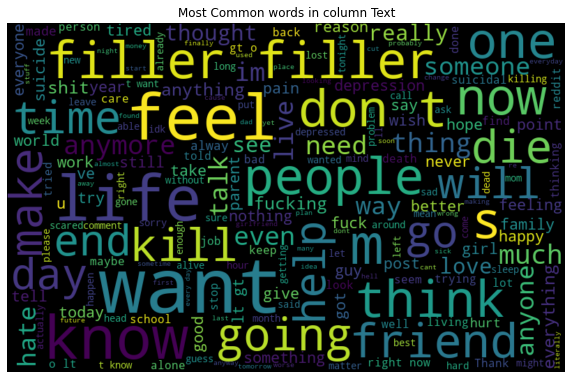

In [60]:
cloudwords = ' '.join([text for text in voc['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(cloudwords)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Text")
plt.show();

This second have the most frequent words written by the people with depressive tendencies:

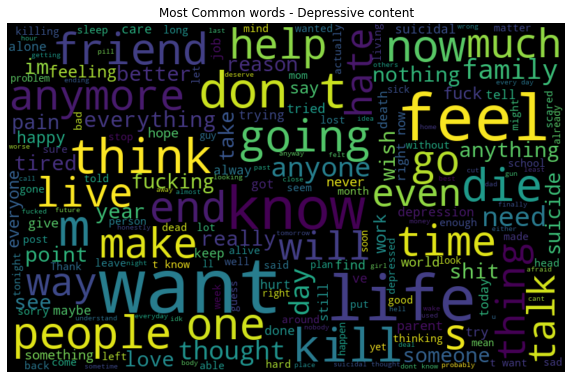

In [61]:
cloudwords_dep = ' '.join([text for text in dep['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(cloudwords_dep)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words - Depressive content")
plt.show();

# NLP - Detection of posts with depressive content
## Creating the model

### Defining a function to clean a post

In [62]:
def clean_post(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [63]:
posts_cleaned = data.copy()

In [64]:
posts_cleaned

,text,class
84369,Is meatloaf a normal thing Because it's always...,0
85721,"I'm feeling guilty.Yesterday, I was sexually h...",1
45469,Since it has been some years since I reviewed ...,0
96990,I may or may not be missing a friend Shit!!! T...,0
204560,"Hey you, you've been almost all day in the int...",0
...,...,...
85060,16 months.Ive been at the end of my rope for a...,1
66152,Is capitalizing your name when writing it or t...,0
179285,Pretty I will always be angry I wasn’t born pr...,1
4481,Loved it! This has to be the best horror flick...,0


In [65]:
posts_cleaned['text'] = posts_cleaned['text'].apply(lambda x: clean_post(x)) 

In [66]:
posts_cleaned.head()

,text,class
84369,is meatloaf a normal thing because it s always...,0
85721,i m feeling guilty yesterday i was sexually ha...,1
45469,since it has been some years since i reviewed ...,0
96990,i may or may not be missing a friend shit too ...,0
204560,hey you you ve been almost all day in the inte...,0


In [67]:
posts_cleaned.to_csv("posts_cleaned.csv")

### Reducing the corpus

In a large text corpus, some words that carry very little meaningful information will be present to concatenate terms(e.g. “the”, “a”, “is” in English). They are useless for our pourposses and could shadow the frequencies of rarer yet more interesting terms. We will create a list with the set of stop words from nltk libraryin order to re-weight the count features into floating point values suitable for usage by a classifier, through the tf–idf transform.


In [68]:
stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Cleaning the punctuation marks in stop words...

In [69]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])

stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

### TF-IDF 

In [70]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words )

In [71]:
X = tidf.fit_transform(posts_cleaned['text'])
y = posts_cleaned['class']

Inspecting the features of the bigrams the model:

In [72]:
tidf.get_feature_names()

['aamir khan',
 'abbott costello',
 'ability make',
 'able afford',
 'able anything',
 'able capture',
 'able control',
 'able enjoy',
 'able feel',
 'able find',
 'able get',
 'able give',
 'able go',
 'able handle',
 'able help',
 'able hold',
 'able keep',
 'able kill',
 'able live',
 'able make',
 'able move',
 'able pay',
 'able play',
 'able pull',
 'able relate',
 'able say',
 'able see',
 'able sleep',
 'able stop',
 'able take',
 'able talk',
 'able tell',
 'able understand',
 'able use',
 'able watch',
 'abraham lincoln',
 'absolute must',
 'absolute shit',
 'absolutely amazing',
 'absolutely beautiful',
 'absolutely brilliant',
 'absolutely fantastic',
 'absolutely hate',
 'absolutely hilarious',
 'absolutely love',
 'absolutely loved',
 'absolutely nothing',
 'absolutely one',
 'absolutely perfect',
 'absolutely stunning',
 'absolutely wonderful',
 'abusive family',
 'abusive father',
 'abusive household',
 'abusive mother',
 'abusive parents',
 'abusive relationship',
 'ac

In [73]:
len(tidf.get_feature_names())

20000

### Train test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# We don't convert the X_train, X_test back to df because they are spare_matrixes and we 
# don't know the column names anymore

In [75]:
type(X_train)

scipy.sparse.csr.csr_matrix

### Generating the model

In [76]:
rf = RandomForestClassifier(max_depth=100, n_estimators=50)

y_train = y_train.astype('int')
y_test  = y_test.astype('int')

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

### Model evaluation

In [78]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [79]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.66
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     26230
           1       0.98      0.67      0.80     26267

    accuracy                           0.83     52497
   macro avg       0.87      0.83      0.83     52497
weighted avg       0.87      0.83      0.83     52497

Results obtained for the TEST SET
The Cohen's Kappa is: 0.61
              precision    recall  f1-score   support

           0       0.74      0.95      0.83     11268
           1       0.93      0.66      0.77     11231

    accuracy                           0.80     22499
   macro avg       0.83      0.80      0.80     22499
weighted avg       0.83      0.80      0.80     22499



### Grid Search

In [80]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 20,50],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
    }
clf = RandomForestClassifier(random_state=100)

In [81]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [82]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 20, 50]},
             return_train_score=True)

In [83]:
grid_search.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [84]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=4, n_estimators=50)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.8724496929120287


In [85]:
clf.fit(X_train, y_train)

y_train_pred_clf = clf.predict(X_train)
y_test_pred_clf  = clf.predict(X_test)

In [86]:
model_performance_class(y_train, y_train_pred_clf, y_test, y_test_pred_clf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.94
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26230
           1       0.99      0.95      0.97     26267

    accuracy                           0.97     52497
   macro avg       0.97      0.97      0.97     52497
weighted avg       0.97      0.97      0.97     52497

Results obtained for the TEST SET
The Cohen's Kappa is: 0.75
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     11268
           1       0.91      0.84      0.87     11231

    accuracy                           0.88     22499
   macro avg       0.88      0.88      0.88     22499
weighted avg       0.88      0.88      0.88     22499



# Recognizer

In [87]:
def recognizer():
    sentence = input("How are you feeling? \n\n")
    list_sentence = []
    list_sentence.append(clean_post(sentence))
    X = tidf.transform(list_sentence)
    predict= rf.predict(X)[0]
    if predict == 0:
        print("\n")
        print("DETECTON:")
        print("This person may be not depressed.")
    else:
        print("\n")
        print("ALERT:")
        print("This person may be depressed.")

In [96]:
recognizer()

How are you feeling? 

happy


DETECTON:
This person may be not depressed.
